# 1. Author

**Student Name:** Daniel Elston

**Student Number:** 210720147

# 2. Problem Formulation

A large problem with a lot of data collected is background noise. The same applies to audio recordings. Background noises such as other people talking, a cars engine or even electrical noise caused by having your laptop charging while you record an audio. Removing this background noise improves results and makes analysis more clear. This advanced solution is aimed at identifying background noise. 

The background noise itself is closely related to silence for audio files such the ones in use here. Silence could be useful in audio recognition, for example matching periods of silence could help classify an audio signal. For this reason, the advanced solutions is aimed at identifying background noise and silence for use in any further research.

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import librosa.display
import math
import soundfile as sf
import matplotlib.style as ms
from tqdm import tqdm

%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The data is loaded in. For this problem, a dataset consisting of many WAV files, each with either a hum or a whistle to the Harry Potter theme song or the Star Wars theme song.

In [2]:
pathall = '/content/drive/MyDrive/Data/MLEndHW_pub/AllAudio'

In [3]:
sample_pathall = '/content/drive/MyDrive/Data/MLEndHW_pub/AllAudio/*.wav'
files_all = glob.glob(sample_pathall)

len(files_all)

747

# 3. Machine Learning Pipeline

The machine learning pipeline below consists of audio files as an input with transformations in the form of audio feature extraction. The feature extracted for this solution is soley audio silence. Machine learning models are trained with audio silence and executed. The output is a classification of song recogonition.

# 4. Transformation Stage

The input for this model is a dataset containing 747 audio files. There are 4 types of file, each file is either a student humming or whistling to either the Harry Potter or Star Wars theme song. The feature extracted for this solution is audio silence, using the function below.

In [4]:
def getXy_sil(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['song']=='Potter'

    fs = None
    x, fs = librosa.load(file,sr=fs)
    rmse = librosa.feature.rms(x + 0.0001)[0]
    
    silence = 0
    for e in rmse:
        if e <= 0.4 * np.mean(rmse):
            silence += 1
    sil = silence/float(len(rmse))

    xi = [sil]
    X.append(xi)
    y.append(yi)

  return np.array(X), np.array(y)

Each feature extracted was saved as a seperate text file and loaded in from the same filepath as the rest of the data. This saves computing power. Further features extracted in the basic solution have also been loaded as they may be useful in identifying silence.

In [5]:
with open('/content/drive/MyDrive/Data/MLEndHW_pub/f_og.txt', 'rb') as filepath:
  f_og=pickle.load(filepath)

In [6]:
with open('/content/drive/MyDrive/Data/MLEndHW_pub/f_sil.txt', 'rb') as filepath:
  f_sil=pickle.load(filepath)

Each feature is added to a dataframe for easy visualisation of resulting features extracted.

# 5. Modelling

The SVM and RandomForestClassifier (RFC) from Sklearn will be used to train our model and execute the results over all audio files. Using extracted features, machine learning models are trained and executed. 

SVM is a support vector machine that seperates the data based on a regression line that fits the data the best. Once this regression has taken place, the SVM classifies each data point based on which side of the line it lies on.

The RFC constructs many decision trees tasked with classifying each audio feature. Many iterations of the classification algorithm take place, then the RFC takes an average classification as the result.

The XGBClassifier allows the dataset to be treated as a model and therefore enables it to be classified.

# 6. Methodology

The audio silence extracted will now be passed through various modules in order to train our model. Validation sets of the data extracted will be used to test the model and produce a result of how well the model classifies the data for each song type.

Model performances will be validated using metrics such as their accuracy, f1 scores, recall scores, precision scores and finally, their confusion matrices. Model Accuracy, is the most important for this report, as it will tell us how often the classifier is correct in identifying the song name. The f1 score is the mean ratio of the models performance using precision and recall. 

Confusion matrices are shown to visualise the target classification predicted by the model compared to the actual classification. 

# 7. Dataset

The dataset being used to train each model is that of the audio files features that have been extracted. In this case, the audio silence feature is used.

Two random files are loaded and their paths are shown.

In [7]:
n=4
m=5
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files_all[n],sr=fs)
x2, fs2 = librosa.load(files_all[m],sr=fs)
t = np.arange(len(x))/fs

print(files_all[n])
print(files_all[m])

/content/drive/MyDrive/Data/MLEndHW_pub/AllAudio/S5_hum_1_Potter.wav
/content/drive/MyDrive/Data/MLEndHW_pub/AllAudio/S4_hum_1_Potter.wav


Here is an example of the raw data we are working with. The files shown below are randomly chosen.

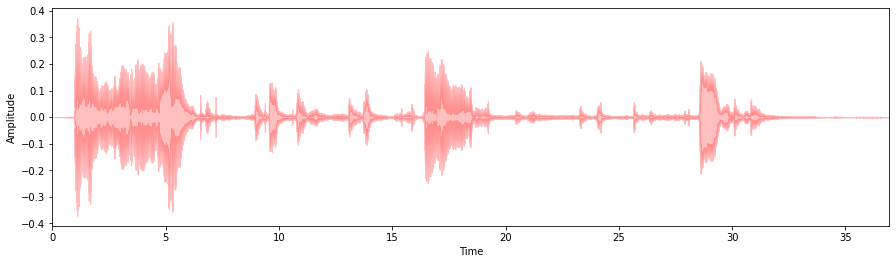

In [8]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(x, max_sr=1000, alpha=0.25, color='r')
plt.ylabel('Amplitude')
plt.show()

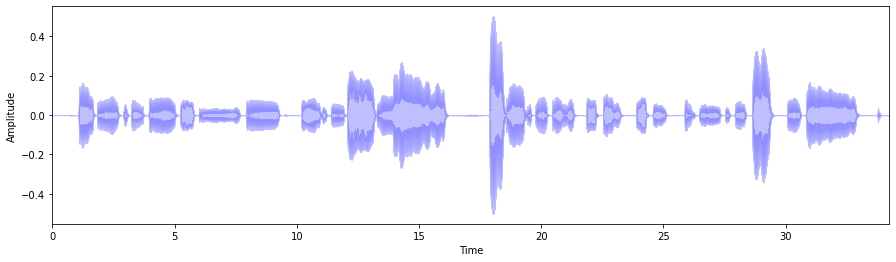

In [9]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(x2, max_sr=1000, alpha=0.25, color='b')
plt.ylabel('Amplitude')
plt.show()

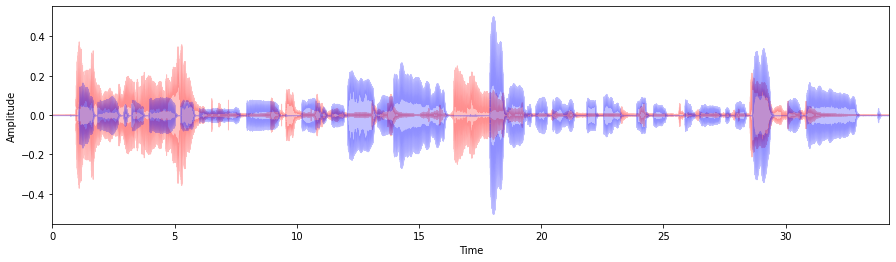

In [10]:
plt.figure(figsize=(15,4))
librosa.display.waveplot(x, max_sr=1000, alpha=0.25, color='r')
librosa.display.waveplot(x2, max_sr=1000, alpha=0.25, color='b')
plt.ylabel('Amplitude')
plt.show()

The code below retreives all files by name.

In [11]:
all_table = [] 

for file in files_all:
  file_name = file.split('/')[-1]
  participant_ID = file.split('/')[-1].split('_')[0]
  interpretation_type = file.split('/')[-1].split('_')[1]
  interpretation_number = file.split('/')[-1].split('_')[2]
  song = file.split('/')[-1].split('_')[3].split('.')[0]
  all_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])

The files are put into a dataframe to easily see their titles and details.

In [12]:
all_df = pd.DataFrame(all_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
all_df

,participant,interpretation,number,song
file_id,,,,
S1_hum_2_Potter.wav,S1,hum,2,Potter
S2_whistle_2_Potter.wav,S2,whistle,2,Potter
S5_hum_2_Potter.wav,S5,hum,2,Potter
S3_hum_1_Potter.wav,S3,hum,1,Potter
S5_hum_1_Potter.wav,S5,hum,1,Potter
...,...,...,...,...
S222_hum_2_StarWars.wav,S222,hum,2,StarWars
S219_hum_3_StarWars.wav,S219,hum,3,StarWars
S218_whistle_2_StarWars.wav,S218,whistle,2,StarWars


The audio silence and file labels are put into a dataframe. Each file is either a Potter file (True) or a Starwars file (False).

In [13]:
x = f_sil[0]
df_sil = pd.DataFrame(x, columns=['Silence'])

In [14]:
z = f_og
labels = z[-1]

Here is the resultant audio silence dataframe.

In [15]:
df = df_sil.assign(Labels = labels)
display(df.head())
print(df.shape)

,Silence,Labels
0,0.450210,True
1,0.368598,True
2,0.373518,True
3,0.117468,True
4,0.606156,True


(747, 2)


# 8. Results

The results of the model and analysis are shown below. To start, the audio silence is normalised.

In [16]:
scaler = StandardScaler()

testy = df['Labels'].to_numpy()
xtest2 = df[['Silence']].to_numpy()
scaler.fit(xtest2)
xte = scaler.transform(xtest2)

The dataset is split into training and validation sets. Each training set will be used to train the model, then the validation sets will be used to test how well the model fits the data.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(xte,testy,test_size=0.25)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((560, 1), (187, 1), (560,), (187,))

Using the SVM module, the dataset is now trained and executed.

In [18]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('The training data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_train, y_pred=model.predict(X_train)))
print('f1 Score:', f1_score(y_true=y_train, y_pred=model.predict(X_train)))
print('Recall Score:', recall_score(y_true=y_train, y_pred=model.predict(X_train)))
print('Precision Score:', precision_score(y_true=y_train, y_pred=model.predict(X_train)))
print('\n')
print('The validation data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_val, y_pred=model.predict(X_val)))
print('f1 Score:', f1_score(y_true=y_val, y_pred=model.predict(X_val)))
print('Recall Score:', recall_score(y_true=y_val, y_pred=model.predict(X_val)))
print('Precision Score:', precision_score(y_true=y_val, y_pred=model.predict(X_val)))
print('\n')
print('The support vectors are', model.support_vectors_.shape, ('\n'))

tcm = confusion_matrix(y_true=y_train, y_pred=model.predict(X_train))
tcm_n = tcm.astype('float') / tcm.sum(axis=1)[:, np.newaxis]

vcm = confusion_matrix(y_true=y_val, y_pred=model.predict(X_val))
vcm_n = vcm.astype('float') / vcm.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(tcm))
print('Validation confusion matrix:\n {}\n'.format(vcm))

print('Normalised training confusion matrix:\n {}\n'.format(tcm_n))
print('Normalised validation confusion matrix:\n {}\n'.format(vcm_n))

The training data metrics are:
Accuracy Score: 0.5535714285714286
f1 Score: 0.31693989071038253
Recall Score: 0.21481481481481482
Precision Score: 0.6041666666666666


The validation data metrics are:
Accuracy Score: 0.47593582887700536
f1 Score: 0.2794117647058823
Recall Score: 0.1958762886597938
Precision Score: 0.48717948717948717


The support vectors are (517, 1) 

Training confusion matrix:
 [[252  38]
 [212  58]]

Validation confusion matrix:
 [[70 20]
 [78 19]]

Normalised training confusion matrix:
 [[0.86896552 0.13103448]
 [0.78518519 0.21481481]]

Normalised validation confusion matrix:
 [[0.77777778 0.22222222]
 [0.80412371 0.19587629]]



The results of the SVM classifier on accuracy of the training dataset are poor. Around 53% of the time it returns the correct label. The results of accuracy on the validation  are even worse, only returning the correct label approximately 51% of the time. All metrics follow a similar pattern. In deployment, this alogrithm would not work.

The results are poor again showing great uncertainty in our models decisions.

Using the RFC, the dataset is now trained and executed.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=300)

clf.fit(X_train, y_train)
y_pred=clf.predict(X_val)

print('The training data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('f1 Score:', f1_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Recall Score:', recall_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Precision Score:', precision_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('\n')
print('The validation data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_val, y_pred=clf.predict(X_val)))
print('f1 Score:', f1_score(y_true=y_val, y_pred=clf.predict(X_val)))
print('Recall Score:', recall_score(y_true=y_val, y_pred=clf.predict(X_val)))
print('Precision Score:', precision_score(y_true=y_val, y_pred=clf.predict(X_val)))
print('\n')
print('The support vectors are', model.support_vectors_.shape, ('\n'))

tcm = confusion_matrix(y_true=y_train, y_pred=clf.predict(X_train))
tcm_n = tcm.astype('float') / tcm.sum(axis=1)[:, np.newaxis]

vcm = confusion_matrix(y_true=y_val, y_pred=clf.predict(X_val))
vcm_n = vcm.astype('float') / vcm.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(tcm))
print('Validation confusion matrix:\n {}\n'.format(vcm))

print('Normalised training confusion matrix:\n {}\n'.format(tcm_n))
print('Normalised validation confusion matrix:\n {}\n'.format(vcm_n))

The training data metrics are:
Accuracy Score: 0.5678571428571428
f1 Score: 0.3730569948186528
Recall Score: 0.26666666666666666
Precision Score: 0.6206896551724138


The validation data metrics are:
Accuracy Score: 0.47593582887700536
f1 Score: 0.3194444444444444
Recall Score: 0.23711340206185566
Precision Score: 0.48936170212765956


The support vectors are (517, 1) 

Training confusion matrix:
 [[246  44]
 [198  72]]

Validation confusion matrix:
 [[66 24]
 [74 23]]

Normalised training confusion matrix:
 [[0.84827586 0.15172414]
 [0.73333333 0.26666667]]

Normalised validation confusion matrix:
 [[0.73333333 0.26666667]
 [0.7628866  0.2371134 ]]



The results of the RFC on accuracy of the training dataset are poor once again. Around 58% of the time it returns the correct label. The results of accuracy on the validation  are even worse, only returning the correct label approximately 51% of the time. All metrics follow a similar pattern. In deployment, this alogrithm would not work.

The results of the matrices are poor again showing great uncertainty in the models decisions.

In [20]:
xgbc = XGBClassifier()
XGBClassifier(base_score=1, objective='multi:softprob') 

xgbc.fit(X_train, y_train)

print('The training data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_train, y_pred=xgbc.predict(X_train)))
print('f1 Score:', f1_score(y_true=y_train, y_pred=xgbc.predict(X_train)))
print('Recall Score:', recall_score(y_true=y_train, y_pred=xgbc.predict(X_train)))
print('Precision Score:', precision_score(y_true=y_train, y_pred=xgbc.predict(X_train)))
print('\n')
print('The validation data metrics are:')
print('Accuracy Score:', accuracy_score(y_true=y_val, y_pred=xgbc.predict(X_val)))
print('f1 Score:', f1_score(y_true=y_val, y_pred=xgbc.predict(X_val)))
print('Recall Score:', recall_score(y_true=y_val, y_pred=xgbc.predict(X_val)))
print('Precision Score:', precision_score(y_true=y_val, y_pred=xgbc.predict(X_val)))
print('\n')
print('The support vectors are', model.support_vectors_.shape, ('\n'))

tcm = confusion_matrix(y_true=y_train, y_pred=xgbc.predict(X_train))
tcm_n = tcm.astype('float') / tcm.sum(axis=1)[:, np.newaxis]

vcm = confusion_matrix(y_true=y_val, y_pred=xgbc.predict(X_val))
vcm_n = vcm.astype('float') / vcm.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(tcm))
print('Validation confusion matrix:\n {}\n'.format(vcm))

print('Normalised training confusion matrix:\n {}\n'.format(tcm_n))
print('Normalised validation confusion matrix:\n {}\n'.format(vcm_n))

The training data metrics are:
Accuracy Score: 0.6732142857142858
f1 Score: 0.5924276169265034
Recall Score: 0.4925925925925926
Precision Score: 0.7430167597765364


The validation data metrics are:
Accuracy Score: 0.48128342245989303
f1 Score: 0.37419354838709673
Recall Score: 0.29896907216494845
Precision Score: 0.5


The support vectors are (517, 1) 

Training confusion matrix:
 [[244  46]
 [137 133]]

Validation confusion matrix:
 [[61 29]
 [68 29]]

Normalised training confusion matrix:
 [[0.84137931 0.15862069]
 [0.50740741 0.49259259]]

Normalised validation confusion matrix:
 [[0.67777778 0.32222222]
 [0.70103093 0.29896907]]



The results of the RFC classifier on accuracy of the training dataset are poor. Around 69% of the time it returns the correct label. The results of accuracy on the validation are worse again, returning the correct label approximately 50% of the time. In deployment, again, this alogrithm would not work.

The confusion matrices show a similar story. The model has struggled to classify the audio files.


# 9. Conclusion

The aim of this machine learning pipeline was to classify audio files based on their audio silence. In theory, this would provide an accurate way of classifying audio files. The audio silence seemed to be an important feature. There would likely be a great difference in the amount of silence each song type had and thus would allow for easy classification. However the result was far from expected and the algorithm did not work as intended, the reasons for which I can only assume were down to human error. 

All classification models failed to provide any reliable results. At the very least, this pipeline could be used to eliminate low volume background noise in areas of further research. 